## Description
This notebook demonstrates how to compute the SW ERFaci from liquid clouds using cloud radiative kernels in an illustrative climate model (E3SMv2) using the difference between piClim-aer vs piClim-control simulations. Additionally, this script demonstrates how to compute the Duran et al (preprint) decomposition of ERFaci into components due to changes in cloud amount, effective radius, liquid water path, and a residual. Finally, it includes calculations to account for changes in obscuration of low clouds by upper-level clouds as discussed in Scott et al (2020), Zelinka et al (2022), and Zelinka et al (preprint). This notebook and associated python code was adapted from the ISCCP CRK approach of Mark Zelinka, and largely follows the process outlined there.

## Input
- ts,clmodis_lwpr,cltmodis,fsdsc,fsnsc (surface temperature, new MODIS re-LWP joint histogram, MODIS total cloud fraction, Clearsky downwelling solar flux at surface, Clearsky net solar flux at surface)
- cloud radiative kernel

## References
- Zelinka, M. D., S. A. Klein, and D. L. Hartmann, 2012: [Computing and Partitioning Cloud Feedbacks Using 
    Cloud Property Histograms. Part I: Cloud Radiative Kernels](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-11-00248.1). J. Climate, 25, 3715-3735. 
    doi:10.1175/JCLI-D-11-00248.1.
- Zelinka, M. D., S. A. Klein, and D. L. Hartmann, 2012: [Computing and Partitioning Cloud Feedbacks Using 
    Cloud Property Histograms. Part II: Attribution to Changes in Cloud Amount, Altitude, and Optical Depth](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-11-00249.1). 
    J. Climate, 25, 3736-3754. doi:10.1175/JCLI-D-11-00249.1.
- Zelinka, M.D., S.A. Klein, K.E. Taylor, T. Andrews, M.J. Webb, J.M. Gregory, and P.M. Forster, 2013: 
    [Contributions of Different Cloud Types to Feedbacks and Rapid Adjustments in CMIP5](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-12-00555.1). 
    J. Climate, 26, 5007-5027. doi:10.1175/JCLI-D-12-00555.1.
- Scott, R. C., Myers, T. A., Norris, J. R., Zelinka, M. D., Klein, S. A., Sun, M., and Doelling, D. R., 2020: [Observed Sensitivity of Low-Cloud Radia-
tive Effects to Meteorological Perturbations over the Global Oceans](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD191028.xml). J. Climate, 33, 7717 – 7734.
- Zelinka et al. (2022): [Evaluating climate models’ cloud feedbacks against expert judgement](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JD035198), _J. Geophys. Res._, 127, e2021JD035198, doi:10.1029/2021JD035198.
- Wall, C. J., Storelvmo, T., A. Possner, 2023: [Global observations of aerosol indirect effects from marine liquid clouds](https://acp.copernicus.org/articles/23/13125/2023/). Atmospheric Chemistry and Physics, 23, 13 125–13 141, doi:10.5194/acp-23-13125-2023.
- Zelinka, M., Chao, L.-W., Myers, T., Qin, Y., and Klein, S., preprint: [Technical Note: Recommendations for Diagnosing Cloud Feedbacks and Rapid
Cloud Adjustments Using Cloud Radiative Kernels](https://egusphere.copernicus.org/preprints/2024/egusphere-2024-2782/). EGUsphere, 1–27.
    
## Contact
- Brandon Duran (bmduran@ucsd.edu)

## User Input

In [1]:
model = 'NorESM'

## Import useful functions

In [2]:
import sys 
import os
os.chdir(os.path.expanduser("~/notebooks/github-modis-crk/code")) #change this to match the path to your code directory 
import calc_CloudRadKernel as CRK
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import warnings
import copy

## Get filepaths based on user input

In [3]:
variables = ['TS', 'CLMODIS_LWPR', 'CLTMODIS', 'FSDSC', 'FSNSC']
exps = ['CTL','PDaer']
datadir = "../data/"
filepath={}
for exp in exps:
    filepath[exp]={}   
    for var in variables:
        filepath[exp][var]={}
        filepath[exp][var] = f'{datadir}{exp}/{var}.nc'

## Do all the ERFaci calculations

In [4]:
output = CRK.CloudRadKernel(filepath)#, False) #for feedbacks

get data
CTL
  TS
  CLMODIS_LWPR
  CLTMODIS
  FSDSC
  FSNSC
PDaer
  TS
  CLMODIS_LWPR
  CLTMODIS
  FSDSC
  FSNSC


2024-09-24 11:52:20,679 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-09-24 11:52:20,679 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


get SW kernel
../data/ensmean_SW_kernel.nc
Compute SW ERFaci and its components


## Standard SW ERFaci from liquid clouds (as diagnosed in Duran et al)

2024-09-24 12:00:19,147 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-09-24 12:00:19,147 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


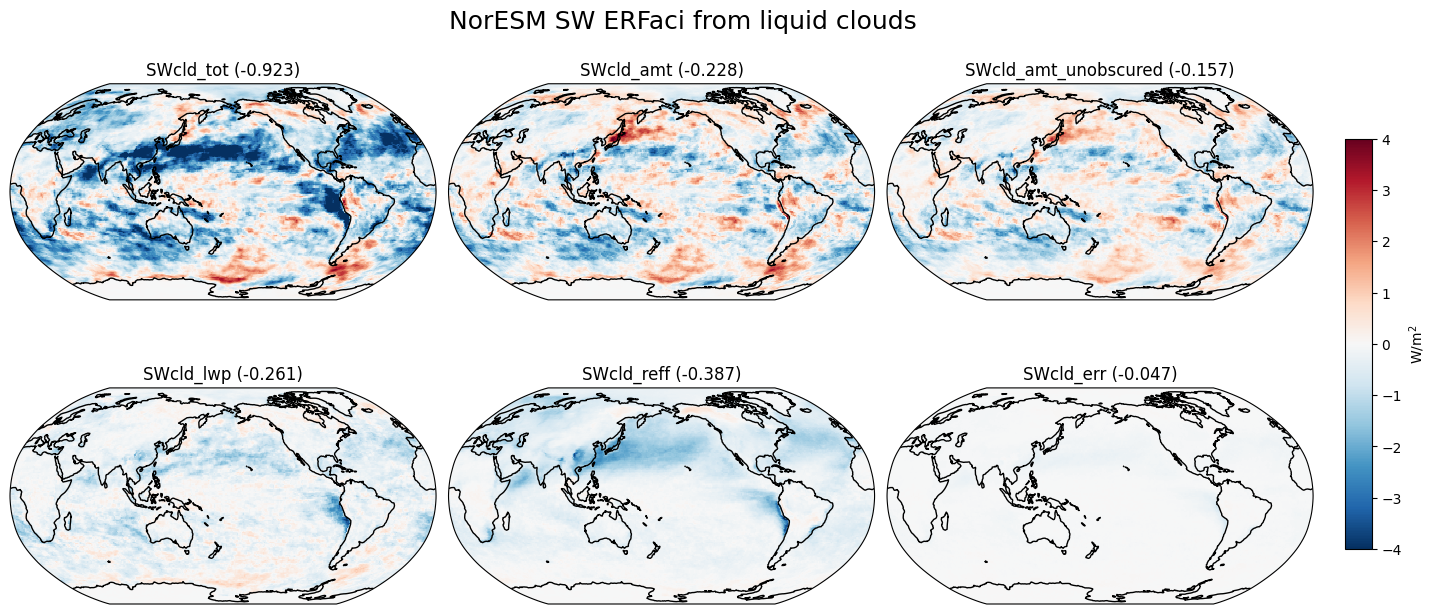

In [5]:
sec = 'ALL' # Use the full histogram
DS = xr.Dataset(output[sec])
avgmap = DS.mean('time')
avgmap=avgmap.bounds.add_missing_bounds()
fig = plt.figure(figsize = (16,7))
plt.suptitle(model+' SW ERFaci from liquid clouds',fontsize=18,x=0.43,y=0.95)
axes = fig.subplots(nrows=2, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
cnt=-1
for row in range(2):
    for col in range(3):
        cnt+=1
        var = fields[cnt]
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        std_dev = avgmap.std()
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -4, vmax = 4,
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        axes[row,col].set_title('{} ({:.3f})'.format(var,avg))
        axes[row,col].coastlines()
plt.tight_layout()
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.65, aspect = 15, label="W/m$^2$")

#### Save Decomposition results

In [ ]:
DS.to_netcdf(f'/home/bmduran/notebooks/make-figs/data/{model}-erfaci-decomposition.nc')

## Accounting for Obscuration Effects

The method for diagnosing the CF adjustment is limited because cloud obscuration effects can alias into the estimated liquid-cloud CF adjustment. This may occur because MODIS reports the phase and cloud-top pressure of the highest cloud in each column it views. Therefore, if ice clouds were to expand in area, then the satellite-reported liquid-cloud fraction can decrease simply because there is a smaller fraction of the gridbox that is unobscured by ice clouds, even if the liquid clouds themselves stay the same. <br><br>
To control for cloud obscuration effects, we introduce the non-obscured liquid-cloud fraction, which is similar to the normal liquid-cloud fraction except that is computed relative to the area of the gridbox that is not obscured by non-liquid clouds
rather than the total area of the gridbox. Let *𝐶*<sub>tot</sub> be the standard liquid-cloud fraction
reported by MODIS (summed over all LWP-CER histogram bins), and let *𝐼*<sub>tot</sub> be the
standard non-liquid cloud fraction reported by MODIS. *𝐼*<sub>tot</sub> can be computed by
subtracting *𝐶*<sub>tot</sub> from the standard total cloud fraction for clouds of all phases reported by MODIS, which is available in the model output. To correct for obscuration effects, we replace the anomaly of *𝐶*<sub>tot</sub> in the standard Zelinka-based formula for the CF adjustment with the following variable:

$$
\mathrm{C_{tot} = \left(\cfrac{C_{tot}}{[100 - I_{tot}]}\right)^{'} (100\% - \overline{I_{tot}})},
$$

where primes denote anomalies (cloud fraction from PDaer simulation minus cloud fraction from CTL simulation) and overbars denote mean-state values (cloud fraction from CTL simulation). The variable *𝐶*<sub>tot</sub><sup>′</sup> is called “sum_dc” in calc_CloudRadKernel.py, and the change of variables is made on line 52. This method is described towards the end of Appendix B in Wall et al. 2023, and it is adapted from the method recommended by Scott et al. (2020). Note that cloud obscuration effects do not affect the diagnosed LWP adjustment or Twomey effect, so we only make the correction for the CF adjustment. Also, the correction will only change the original estimate of the CF adjustment if the non-liquid-cloud fraction changes between the PDaer and CTL experiments. <br> <br>

More details can be found in [Scott et al (2020)](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD191028.xml), [Myers et al (2021)](https://www.nature.com/articles/s41558-021-01039-0), [Zelinka et al (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JD035198), and [Wall et al (2023)](https://acp.copernicus.org/articles/23/13125/2023/).

Text(0.5, 1.0, 'c) Unobscured Cloud Fraction Adjustment')

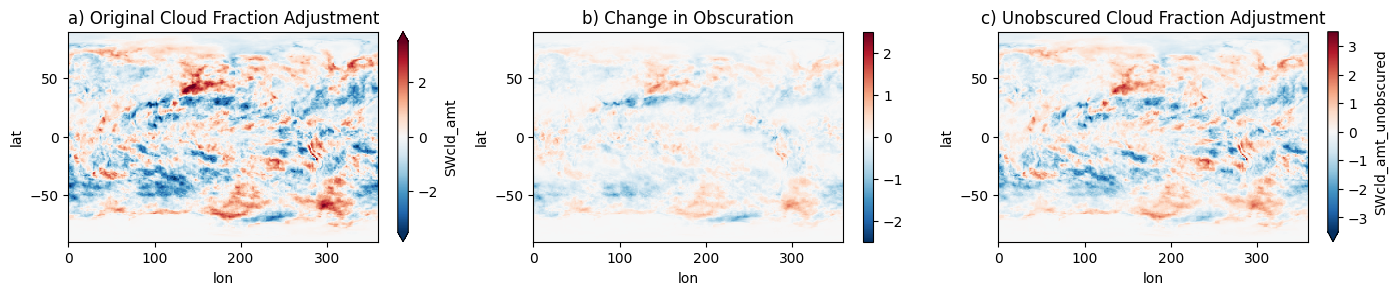

In [10]:
# Compare original and unobscured low cloud feedbacks:
DS = xr.Dataset(output[sec])
plt.figure(figsize=(17,6))
plt.subplot(2,3,1)
A = DS['SWcld_amt'].mean('time')
A.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('a) Original Cloud Fraction Adjustment')
plt.subplot(2,3,2)
B = (DS['SWcld_amt'] - avgmap['SWcld_amt_unobscured']).mean('time')
B.plot(vmin=-2.5,vmax=2.5,cmap='RdBu_r')
plt.title('b) Change in Obscuration')
plt.subplot(2,3,3)
C = DS['SWcld_amt_unobscured'].mean('time')
C.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('c) Unobscured Cloud Fraction Adjustment')